# Generating Training and Test Sets

## Overview
Our approach involved collecting time series data for the closing prices of 100 of the top stocks in the market. We divided the data into chunks of 120 or 270 days to enhance the readability of the resulting spectrograms. The time series were then transformed into time-frequency representations using wavelet transformation. We then applied a label to each spectrogram that was derived by the average trend of the stockin question in the subsequent month from the time frame on which each spectrogram was based.
Several configurations were tested, varying the time lengths, dataset sizes, and preprocessing methods applied to the stock time series. The following steps outline our methodology:

### Data Collection
We utilized the `yfinance` library to download historical stock closing prices from Yahoo Finance.

### Experimentation with Time Lengths and Dataset Splits
1. **Initial Configuration:**
   - **Training Set:** Spectrograms generated from time series of 120 days (later extended to 270 days in a second experiment) for data spanning from 2000 to 2014.
   - **Test Set:** Spectrograms from time series between 2016 and 2019.
   - **Note:** Data were not normalized before applying the wavelet transformation.

2. **Adjusted Training Period:**
   - Restricted the training timeframe to 2010–2014 to reduce the presence of potentially "contradictory spectrograms."
   - **Hypothesis:** Poor model accuracy could stem from similar images in the training set having different labels. However, this was likely not the issue, as the model achieved very high accuracy on the training set regardless.

3. **Balancing Labels:**
   - Balanced the number of spectrogram images for each label.
   - **Hypothesis:** Label 2 (indicating an increase in stock price in the subsequent month of the period the spectrogram was based on) was over-represented in the training set due to the consistent growth of top market stocks. This imbalance was highlighted by the confusion matrix, which showed the model predominantly predicting label 2.

4. **Normalization and Min-Max Scaling:**
   - Applied normalization and, in a separate experiment, Min-Max scaling to the stock time series prior to wavelet transformation.
   - **Objective:** Improve the distinctiveness of the resulting spectrograms.

## Summary
By iteratively adjusting the data preprocessing and training configurations, we explored multiple hypotheses to address issues with model accuracy.

---
## Here are the function used in the process and their variants:

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# List of Stocks (First 10 for demonstration)
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "BRK-B", "NVDA", "JNJ", "JPM", "PG", "UNH", "HD", "MA", "DIS", "NFLX", "KO", "PEP",
            "CSCO", "XOM", "PFE", "MRK", "INTC", "BA", "WMT", "MCD", "IBM", "GS",
            "NKE", "ADBE", "HON", "AMGN", "T", "COST", "ABT", "LMT", "BMY", "CAT",
            "DHR", "MDT", "CVX", "ORCL", "CMCSA", "MS", "ISRG", "TXN", "UNP", "QCOM",
            "LIN", "PM", "SBUX", "AMAT", "MMM", "NEE", "BLK", "SPGI", "NOW", "GE",
            "LLY", "ZTS", "LOW", "TGT", "INTU", "ANTM", "MU", "FIS", "CSX", "VRTX",
            "GILD", "APD", "PLD", "ADI", "C", "DUK", "SYK", "USB", "SO", "SCHW",
            "MMC", "CL", "TJX", "BDX", "CI", "PNC", "CME", "NSC", "EW", "ETN",
            "ADI", "ROP", "FCX", "ICE", "TRV", "TMO", "GM", "AON", "FDX", "HUM"]

In [ ]:
def download_data_with_extension(ticker, start_date, end_date, chunk_size_days, extension_days):
    """
    Download time series data for a given ticker, including an extension for future trend analysis.
    """

    current_date = start_date
    all_data = []

    while current_date < end_date:
        next_date = current_date + timedelta(days=chunk_size_days + extension_days)
        print(f"Downloading {ticker} data from {current_date} to {next_date}...")

        data = yf.download(ticker, start=current_date, end=next_date, progress=False)
        if not data.empty:
            all_data.append(data['Close'])

        current_date = current_date + timedelta(days=chunk_size_days)

    return pd.concat(all_data, axis=0)

In [ ]:
# Step 3: Compute Future Trend Label
def compute_future_trend_label(future_period_prices, threshold=0.005):
    """
    Compute label based on the average price variation between current and future periods:
        2 -> Positive trend (average price increase > threshold)
        1 -> Neutral trend (within ±threshold)
       0 -> Negative trend (average price decrease > threshold)
    """
    if len(future_period_prices) == 0:
        return None

    price_change = (future_period_prices[-1]-future_period_prices[0])/future_period_prices[0]

    if price_change > threshold:
        return 2  # Upwards trend
    elif price_change < -threshold:
        return 0  # Downwards trend
    else:
        return 1  # Neutral trend

In [ ]:
def generate_wavelet_spectrogram(signal, stock_name, period_num, wavelet='morl', scales=None):
    """
    Generate and save a spectrogram image using Continuous Wavelet Transform (CWT).
    """

    if scales is None:
        scales = np.arange(1, 128)

    # OPTIONAL: Normalize The Signal
    # scaler = StandardScaler()
    # normalized_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()

    # OPTIONAL 2: Apply Min-Max Scaling
    # scaler = MinMaxScaler()
    # scaled_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()

    # Perform Continuous Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet)

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coefficients), extent=[0, len(signal), 1, 128],
               interpolation='bilinear', aspect='auto', cmap='jet')
    plt.colorbar(label='Power')
    plt.ylabel('Frequency (Scale)')
    plt.xlabel('Time')

    # Save the image
    image_path = os.path.join(output_dir, f"{stock_name}_Period{period_num}.png")
    plt.savefig(image_path)
    plt.close()
    print(f"Saved spectrogram: {image_path}")

    return image_path

In [ ]:
# A function to balance the number of images for each label in the train set
def balance_labels(labels, max_per_label):

    # Convert to DataFrame for easier manipulation
    labels_df = pd.DataFrame(labels, columns=["image_path", "label"])

    # Group by label
    balanced_labels = []
    for label in labels_df['label'].unique():
        label_group = labels_df[labels_df['label'] == label]

        # Sample max_per_label entries from each group
        if len(label_group) > max_per_label:
            label_group = label_group.sample(n=max_per_label, random_state=42)

        balanced_labels.append(label_group)

    # Concatenate balanced groups and convert back to list
    balanced_labels_df = pd.concat(balanced_labels)
    return balanced_labels_df.values.tolist()

In [ ]:
# Step 6: Process Stocks and Save Labels
def process_stocks(tickers, start_date, end_date, chunk_size_days=120, extension_days=30, threshold=0.01, max_per_label=300):

    labels = []

    for ticker in tickers:
        print(f"Processing {ticker}...")
        try:
            # Download data with extension for future trend analysis
            close_prices = download_data_with_extension(ticker, start_date, end_date, chunk_size_days, extension_days)
            close_prices = close_prices.dropna()

            if len(close_prices) == 0:
                print(f"No valid data for {ticker}. Skipping...")
                continue

            # Process each 100-day period
            period_num = 1
            for i in range(0, len(close_prices) - chunk_size_days - extension_days + 1, chunk_size_days):
                current_chunk = close_prices.iloc[i:i + chunk_size_days].values
                future_chunk = close_prices.iloc[i + chunk_size_days:i + chunk_size_days + extension_days].values

                if len(current_chunk) < 2 or len(future_chunk) < 2:
                    continue

                # Compute label based on future trend
                label = compute_future_trend_label(future_chunk, threshold)
                if label is None:
                    continue

                # Generate and save spectrogram
                image_path = generate_wavelet_spectrogram(current_chunk, ticker, period_num)

                # Append to labels list
                labels.append([image_path, label])
                period_num += 1

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    # Save labels to CSV
    labels_df = pd.DataFrame(labels, columns=["image_path", "label"])
    labels_df.to_csv(label_file, index=False)
    print(f"Labels saved to {label_file}")

    # OPTIONAL:
    # Balance the dataset
    # balanced_labels = balance_labels(labels, max_per_label)

    # Save balanced labels to CSV
    # balanced_labels_df = pd.DataFrame(balanced_labels, columns=["image_path", "label"])
    # balanced_labels_df.to_csv(label_file, index=False)
    # print(f"Balanced labels saved to {label_file}")

## This code below was used to initialize the process:

In [ ]:
# Create Directory to Save Images and Labels
output_dir = "spectrograms_train" #here we simply changed the mane of the fodlder when we wanted to create the train set
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

label_file = os.path.join(output_dir, "labels.csv")

start_date = datetime(2000, 1, 1)
end_date = datetime(2014, 1, 1)

# Generate the spectrograms
process_stocks(tickers, start_date, end_date)


In [ ]:
output_dir = "spectrograms_test" # here we changed the folder name to be the test set folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

label_file = os.path.join(output_dir, "labels.csv")

start_date = datetime(2016, 1, 1)
end_date = datetime(2019, 1, 1)

# Generate the spectrograms
process_stocks(tickers, start_date, end_date)

---
# Visual Transformer Model

## What is a Visual Transformer (ViT)?
A Visual Transformer (ViT) is a deep learning model architecture that applies Transformer models, originally designed for natural language processing, to image data. Unlike convolutional neural networks (CNNs), which rely on spatial hierarchies of image features, ViTs divide an image into fixed-size patches, linearly embed these patches, and then process them using standard Transformer layers.

### Key Characteristics of Visual Transformers:
- **Patch Embedding:** Images are divided into non-overlapping patches (e.g., 16x16 pixels). These patches are flattened and projected into a higher-dimensional embedding space.
- **Position Encodings:** To retain spatial relationships between patches, position embeddings are added to the patch embeddings.
- **Attention Mechanism:** The model uses self-attention layers to capture global context across the entire image, enabling it to understand complex relationships between patches.

ViT models have shown competitive performance compared to CNNs in image recognition tasks, particularly when pre-trained on large datasets.

---

## What is the BiT-Base-Patch16 Model?
BiT-Base-Patch16 refers to a **Vision Transformer model pre-trained by Google**:
- **BiT (Big Transfer):** A training paradigm that leverages large-scale datasets and transfer learning for improved performance. BiT uses extensive datasets like ImageNet-21k to pre-train the model before fine-tuning on smaller, task-specific datasets.
- **Base Architecture:** This refers to the size of the model, with "Base" typically indicating a model with fewer parameters compared to "Large" or "Huge" variants.
- **Patch16:** This indicates the image is divided into 16x16 pixel patches for processing.

This particular model is well-suited for tasks that benefit from pre-trained representations and handles inputs normalized to the model’s specifications.

---

## Introduction to the Code
The provided code demonstrates how to fine-tune a pre-trained Vision Transformer (ViT) model for an image classification task using spectrograms as inputs. The workflow includes:

1. **Data Preparation:**
    - Loading spectrogram images and their labels for training and testing.
    - Transforming the input spectrograms into the required format for the Vision Transformer.

2. **Model Setup:**
    - Using the pre-trained ViT model (`google/vit-base-patch16-224-in21k`), which has been pre-trained on large datasets for strong initial feature representations.
    - Normalizing the inputs and adapting the pre-trained model to the spectrogram dataset.

3. **Training:**
    - Implementing a training loop with early stopping based on a loss threshold to prevent overfitting.
    - Leveraging transfer learning to fine-tune the ViT model for spectrogram classification.

4. **Evaluation:**
    - Generating predictions on the test set.
    - Calculating classification accuracy.
    - Plotting confusion matrices to visualize model performance.
    - Saving predictions and labels for further analysis.


In [4]:
import os
import zipfile
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Below is the code used for each phase of the training and testing, with some of the outputs from the different varaitions of the train set.

In [ ]:
%rm -rf /content/Unzipped # this is used to remove the unzipped folder from colab

In [5]:
# the code below was used to unzip the zipped folders with the train and test set that we uploaded to Colab

# Check uploaded files
train_zip_file = "spectrograms_train.zip"
test_zip_file = "spectrograms_test.zip"


# Extraction directories
extract_base_dir = "/content/Unzipped/"
train_extract_dir = os.path.join(extract_base_dir, "spectrograms_train")
test_extract_dir = os.path.join(extract_base_dir, "spectrograms_test")

# Ensure directories exist
os.makedirs(train_extract_dir, exist_ok=True)
os.makedirs(test_extract_dir, exist_ok=True)

# Unzip train folder
with zipfile.ZipFile(train_zip_file, 'r') as zip_ref:
    zip_ref.extractall(train_extract_dir)
print(f"'spectrograms_train.zip' extracted to {train_extract_dir}")

# Unzip test folder
with zipfile.ZipFile(test_zip_file, 'r') as zip_ref:
    zip_ref.extractall(test_extract_dir)
print(f"'spectrograms_test.zip' extracted to {test_extract_dir}")

# Confirm extraction
print("\nTrain Folder Contents:", os.listdir(train_extract_dir))
print("Test Folder Contents:", os.listdir(test_extract_dir))

'spectrograms_train.zip' extracted to /content/Unzipped/spectrograms_train
'spectrograms_test.zip' extracted to /content/Unzipped/spectrograms_test

Train Folder Contents: ['spectrograms_train']
Test Folder Contents: ['spectrograms_test']


In [6]:
# Configuration
BATCH_SIZE = 16
EPOCHS = 80
LEARNING_RATE = 0.0001 #the learning rate will be updated each 20 epochs by a factor of 0.1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # we ran this model using google colab A100 so we used Cuda
print(f"Using device: {DEVICE}")

# Dataset Class
class SpectrogramDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(labels_file)
        self.labels["label"] = self.labels["label"].astype(int)  # This is to ensure that labels are integers
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image not found: {img_name}")
        image = Image.open(img_name).convert("RGB")
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

train_image_dir = "/content/Unzipped/spectrograms_train/" #this path was meaningful when using colab, this is because on colab was easier to upload the collection of images as zipped folders
train_labels_file = "/content/Unzipped/spectrograms_train/spectrograms_train/labels.csv"
test_image_dir = "/content/Unzipped/spectrograms_test/"
test_labels_file = "/content/Unzipped/spectrograms_test/spectrograms_test/labels.csv"

Using device: cuda


In [7]:

# We define the transformer
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std) #we normalized the inputs to the model
])

train_dataset = SpectrogramDataset(image_dir=train_image_dir, labels_file=train_labels_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SpectrogramDataset(image_dir=test_image_dir, labels_file=test_labels_file, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# This is the setup of the model
num_classes = len(train_dataset.labels["label"].unique())
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', #this is a pretrained ViT provided by google
    num_labels=num_classes
)
model.to(DEVICE)

# Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1) # this has the job of updating the learning rate


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# This function does the evaluation of the model on the test set
def evaluate_model(output_csv_path="predictions.csv"):
    model.eval()
    true_labels = []
    pred_labels = []
    image_names = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)

            # Store true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
            image_names.extend([test_dataset.labels.iloc[idx, 0] for idx in range(len(labels))])

    # Calculate the accuracy on the test set
    accuracy = np.sum(np.array(true_labels) == np.array(pred_labels)) / len(true_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # here we create the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # We also save the predicted labels and the original ones into a csv
    predictions_df = pd.DataFrame({"Image": image_names, "True Label": true_labels, "Predicted Label": pred_labels})
    predictions_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

In [9]:
# Training Loop with Loss, Accuracy, and Validation Metrics
def train_model(threshold_loss=0.2): #optional threshold for stopping condition
    train_accuracies = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        # Initialize the training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Initialize validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images).logits
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(test_loader)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # print the epoch's metrics
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.6f}, Accuracy: {train_accuracy * 100:.2f}%, "
              f"Val Loss: {avg_val_loss:.6f}, Val Accuracy: {val_accuracy * 100:.2f}%")

        # Update learning rate scheduler
        scheduler.step()  # For StepLR
        print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.9f}")

        # Check for early stopping condition
        if avg_loss <= threshold_loss:
            print(f"Stopping early at epoch {epoch + 1} as loss reached {avg_loss:.4f}")
            break

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid()
    plt.show()



## FIRST OUTPUT: Train Set 2000-2014 not Balanced not Normalized, Test Set 2016-2019.

### Here is an example spectrogram from this dataset:

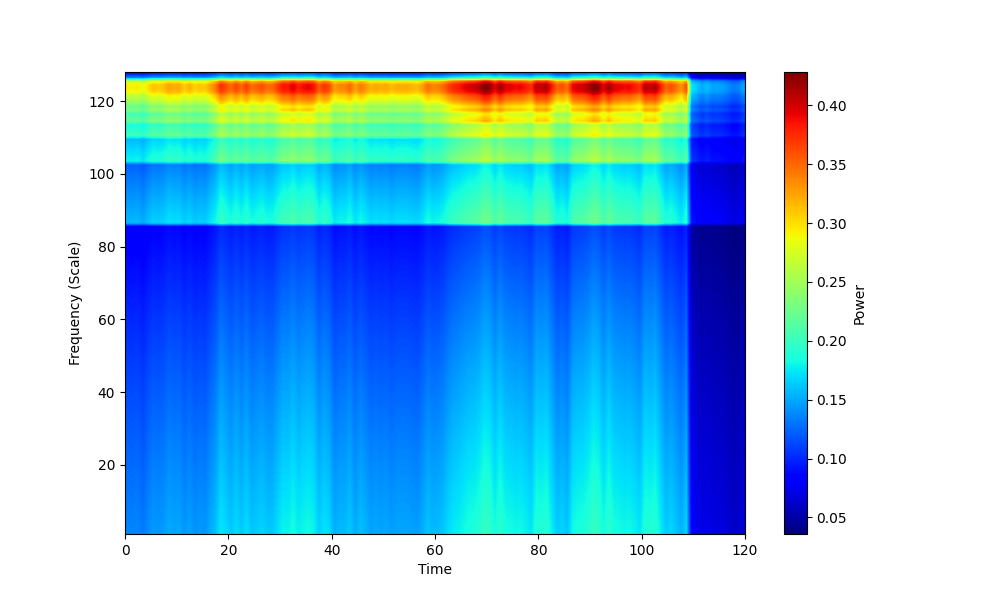

Starting Training...
Epoch 1/80, Loss: 0.990446, Accuracy: 46.35%, Val Loss: 0.956754, Val Accuracy: 55.66%
Current Learning Rate: 0.000100000
Epoch 2/80, Loss: 0.982648, Accuracy: 46.81%, Val Loss: 0.963274, Val Accuracy: 55.66%
Current Learning Rate: 0.000100000
Epoch 3/80, Loss: 0.980821, Accuracy: 47.18%, Val Loss: 0.957000, Val Accuracy: 55.66%
Current Learning Rate: 0.000100000
Epoch 4/80, Loss: 0.976682, Accuracy: 48.57%, Val Loss: 0.978245, Val Accuracy: 47.37%
Current Learning Rate: 0.000100000
Epoch 5/80, Loss: 0.975449, Accuracy: 47.64%, Val Loss: 0.977762, Val Accuracy: 55.66%
Current Learning Rate: 0.000100000
Epoch 6/80, Loss: 0.974227, Accuracy: 49.03%, Val Loss: 0.957988, Val Accuracy: 54.21%
Current Learning Rate: 0.000100000
Epoch 7/80, Loss: 0.967777, Accuracy: 49.65%, Val Loss: 0.960707, Val Accuracy: 54.61%
Current Learning Rate: 0.000100000
Epoch 8/80, Loss: 0.966519, Accuracy: 51.13%, Val Loss: 0.975724, Val Accuracy: 49.08%
Current Learning Rate: 0.000100000
Epo

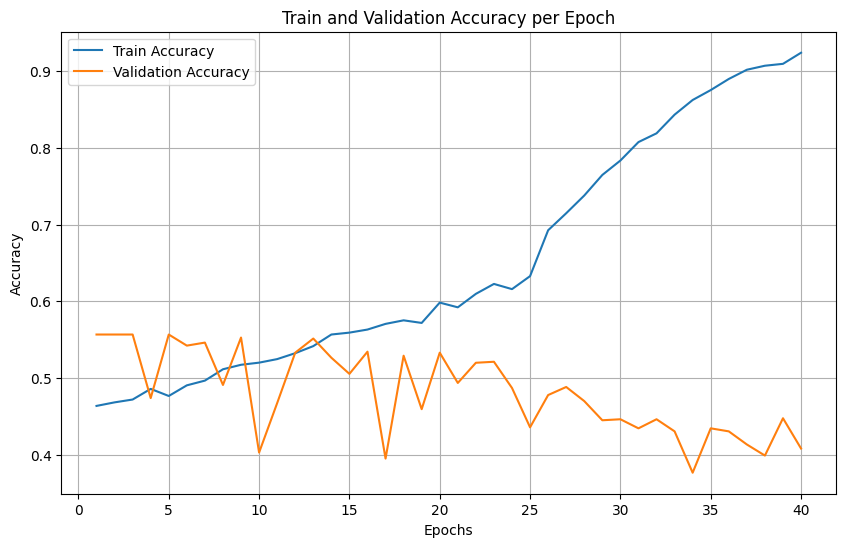

Evaluating Model...
Accuracy: 40.79%


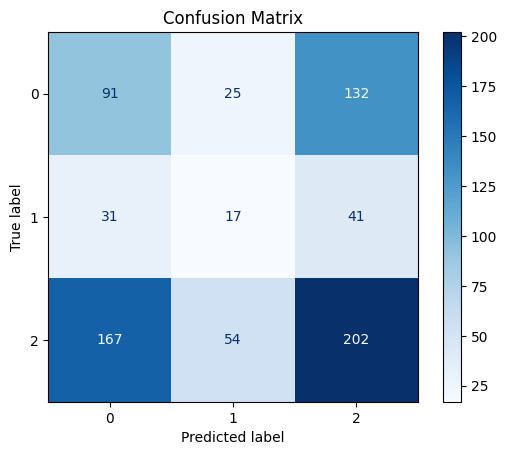

Predictions saved to predictions.csv


In [ ]:
print("Starting Training...")
train_model()
print("Evaluating Model...")
evaluate_model()

### Upon evaluating the model's performance on the test set, it was observed that the model does not effectively classify the spectrograms. While the accuracy occasionally reaches approximately 50% during some epochs, a detailed inspection reveals that this is primarily attributed to an inherent characteristic of the dataset. Specifically, the dataset contains a disproportionately large number of samples labeled as '2' (indicating growth) compared to other classes. As a result, during the initial training epochs, the model achieves moderate performance by predominantly predicting label '2'. This imbalance in label distribution likely stems from the nature of the selected dataset, which consists of the top 100 market stocks that are inherently biased towards growth over time. This imbalance skews the model's learning process and inflates early-stage accuracy artificially.

### To address this issue, we plan to incorporate corrective measures, such as rebalancing the dataset in the third iteration of the train dataset's development.
---

## SECOND OUTPUT: Train Set 2010-2014 not Balanced not Normalized, Test Set 2015.


Starting Training...
Epoch 1/80, Loss: 0.979980, Accuracy: 53.21%, Val Loss: 0.865708, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 2/80, Loss: 0.967923, Accuracy: 54.18%, Val Loss: 0.886799, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 3/80, Loss: 0.967167, Accuracy: 54.18%, Val Loss: 0.864821, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 4/80, Loss: 0.965505, Accuracy: 54.18%, Val Loss: 0.899315, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 5/80, Loss: 0.965065, Accuracy: 54.18%, Val Loss: 0.910136, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 6/80, Loss: 0.969076, Accuracy: 54.18%, Val Loss: 0.910467, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 7/80, Loss: 0.960357, Accuracy: 54.60%, Val Loss: 0.871717, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 8/80, Loss: 0.961482, Accuracy: 54.50%, Val Loss: 0.881639, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epo

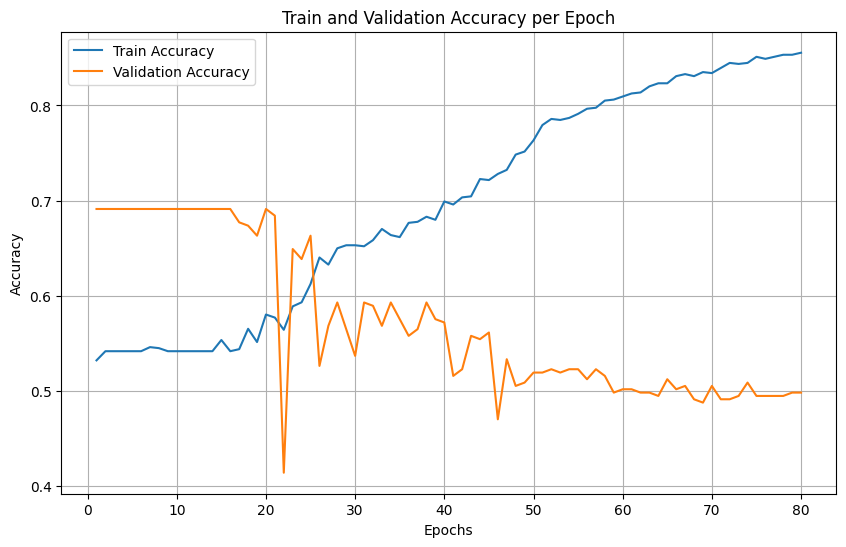

Evaluating Model...
Accuracy: 49.82%


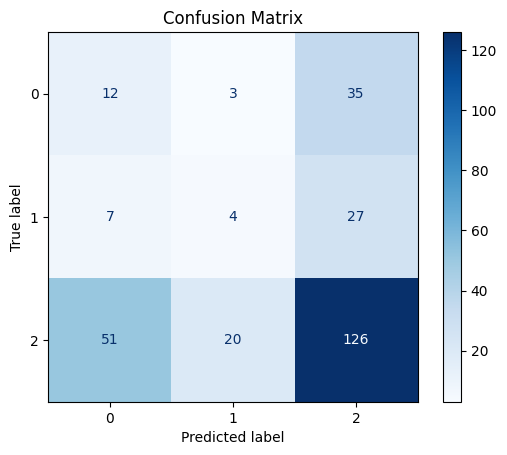

Predictions saved to predictions.csv


In [ ]:
print("Starting Training...")
train_model()
print("Evaluating Model...")
evaluate_model()

### In this iteration of the model, we sought to address another issue observed in the training dataset. Specifically, the issue pertained to the length of the time frame selected for data collection. Our hypothesis was that the dataset might contain many spectrograms with similar patterns but assigned to different labels due to the random fluctuations inherent in stock market behavior. This randomness could create challenges for the model in accurately identifying consistent patterns. Also by reducing the time frame we sought to see if the model would provide "better guesses" if trained on closer years to the one it would be tested on.

### Following these adjustments, we observed a moderate improvement in the model's overall performance. However, the changes did not significantly enhance the model's ability to accurately classify labels '1' and '0'. This suggests that further refinement is required to address these classification challenges effectively.
---

## THIRD OUTPUT: Train Set 2008-2014 Balanced not Normalized, Test Set 2015.

Starting Training...
Epoch 1/80, Loss: 1.076605, Accuracy: 37.37%, Val Loss: 1.012987, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 2/80, Loss: 1.073307, Accuracy: 38.15%, Val Loss: 1.018561, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 3/80, Loss: 1.067247, Accuracy: 40.89%, Val Loss: 1.002857, Val Accuracy: 57.89%
Current Learning Rate: 0.000100000
Epoch 4/80, Loss: 1.069052, Accuracy: 37.50%, Val Loss: 1.028744, Val Accuracy: 17.54%
Current Learning Rate: 0.000100000
Epoch 5/80, Loss: 1.061875, Accuracy: 40.89%, Val Loss: 1.021052, Val Accuracy: 17.89%
Current Learning Rate: 0.000100000
Epoch 6/80, Loss: 1.068824, Accuracy: 38.67%, Val Loss: 1.037419, Val Accuracy: 17.54%
Current Learning Rate: 0.000100000
Epoch 7/80, Loss: 1.068957, Accuracy: 44.66%, Val Loss: 0.929458, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 8/80, Loss: 1.062792, Accuracy: 43.23%, Val Loss: 1.142505, Val Accuracy: 17.54%
Current Learning Rate: 0.000100000
Epo

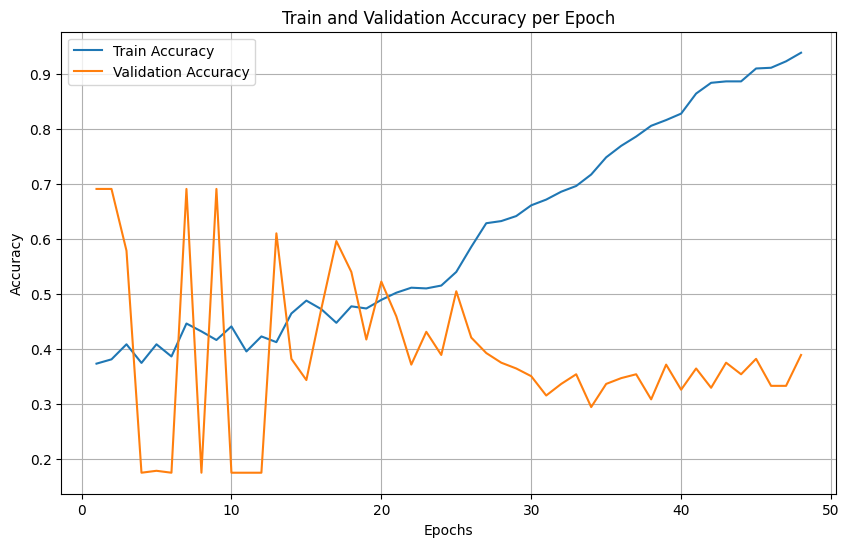

Evaluating Model...
Accuracy: 38.95%


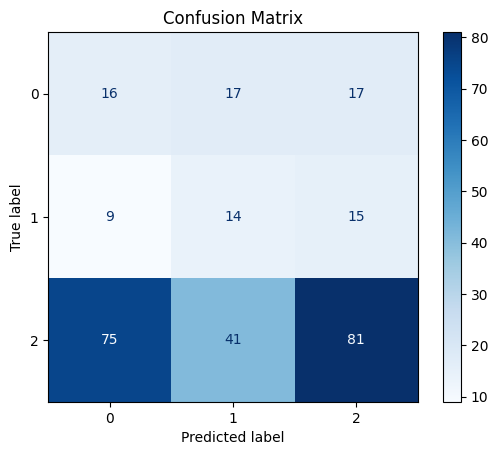

Predictions saved to predictions.csv


In [ ]:
print("Starting Training...")
train_model()
print("Evaluating Model...")
evaluate_model()

### Here we applied balancing to the number of images for each label in the training set to address the imbalance that previously caused the model to overpredict certain labels (e.g., label '2'). While the training accuracy steadily increases, the validation accuracy fluctuates and stabilizes at a lower level, indicating that the model may still struggle to generalize well on unseen data.

### The confusion matrix below reveals that the model still performs inconsistently across labels. It achieves relatively better results for label '2' (growth), but its ability to accurately classify labels '0' (negative trend) and '1' (neutral trend) remains limited. This outcome highlights the challenges posed by the inherent randomness and overlapping features in the dataset, which make distinguishing between certain labels very difficult.
---

## FOURTH OUTPUT: Train Set 2008-2014 Balanced & Normalized, Test Set 2015.


### Here is an example spectrogram from this dataset:


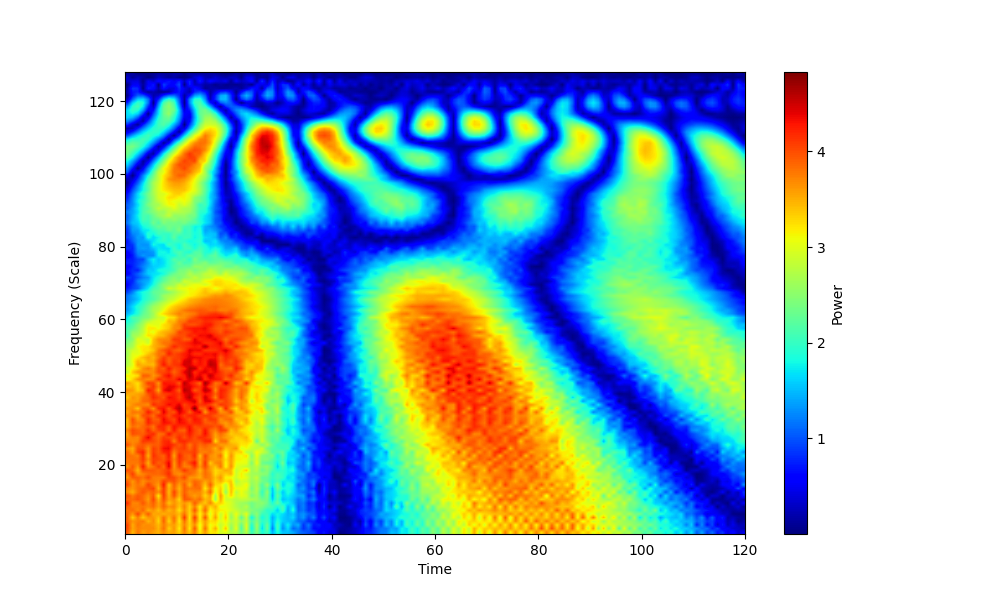

Starting Training...
Epoch 1/80, Loss: 1.080344, Accuracy: 37.24%, Val Loss: 1.053404, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 2/80, Loss: 1.068288, Accuracy: 41.80%, Val Loss: 1.069366, Val Accuracy: 17.54%
Current Learning Rate: 0.000100000
Epoch 3/80, Loss: 1.064453, Accuracy: 42.58%, Val Loss: 0.984305, Val Accuracy: 54.39%
Current Learning Rate: 0.000100000
Epoch 4/80, Loss: 1.059393, Accuracy: 45.31%, Val Loss: 1.020758, Val Accuracy: 49.47%
Current Learning Rate: 0.000100000
Epoch 5/80, Loss: 1.055080, Accuracy: 45.96%, Val Loss: 0.967598, Val Accuracy: 53.68%
Current Learning Rate: 0.000100000
Epoch 6/80, Loss: 1.037361, Accuracy: 48.96%, Val Loss: 1.061487, Val Accuracy: 25.96%
Current Learning Rate: 0.000100000
Epoch 7/80, Loss: 1.054796, Accuracy: 42.32%, Val Loss: 1.031107, Val Accuracy: 40.00%
Current Learning Rate: 0.000100000
Epoch 8/80, Loss: 1.043912, Accuracy: 46.61%, Val Loss: 0.902523, Val Accuracy: 63.16%
Current Learning Rate: 0.000100000
Epo

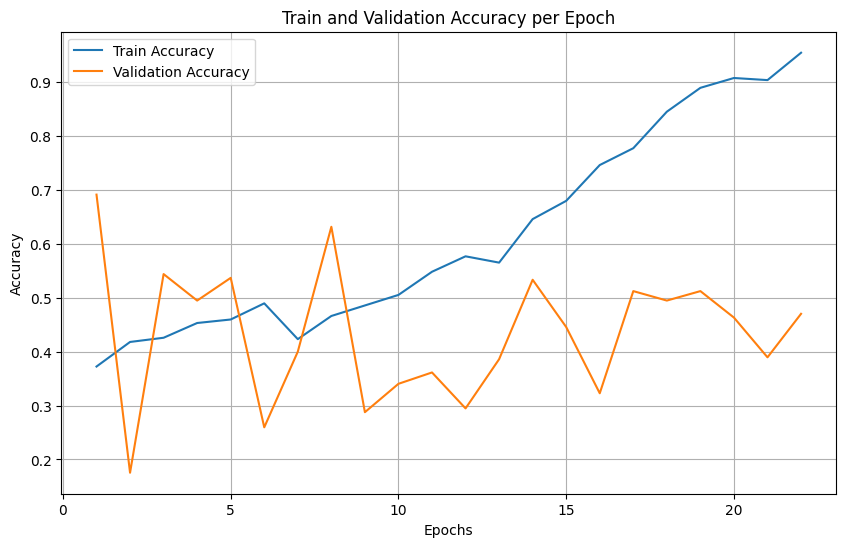

Evaluating Model...
Accuracy: 47.02%


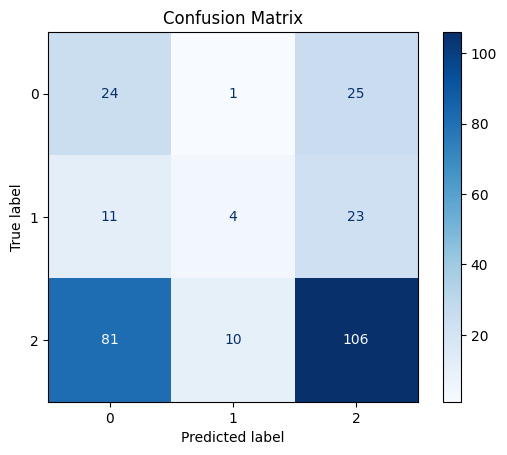

Predictions saved to predictions.csv


In [10]:
print("Starting Training...")
train_model()
print("Evaluating Model...")
evaluate_model()

---
### As an update to what we had done until now, we implemented a mechanism to output a confusion matrix for any epoch where the training accuracy exceeds 60% and the testing accuracy surpasses 55% and stop the training. This threshold was chosen based on the rationale that a test set accuracy of 55% represents a meaningful result, considering that random guessing in this scenario would yield an accuracy of only 33.3%. Due to a simple matter of time and computational resources we used only the dataset for the second case to train the model and then tested it against two different years. Below is the updated code:

Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training...
Epoch 1/80, Loss: 0.987006, Accuracy: 53.10%, Val Loss: 0.924311, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 2/80, Loss: 0.970347, Accuracy: 54.18%, Val Loss: 0.892057, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 3/80, Loss: 0.967178, Accuracy: 54.07%, Val Loss: 0.984142, Val Accuracy: 44.21%
Current Learning Rate: 0.000100000
Epoch 4/80, Loss: 0.944525, Accuracy: 56.64%, Val Loss: 0.886851, Val Accuracy: 69.12%
Current Learning Rate: 0.000100000
Epoch 5/80, Loss: 0.936942, Accuracy: 57.71%, Val Loss: 0.951676, Val Accuracy: 59.65%
Current Learning Rate: 0.000100000
Epoch 6/80, Loss: 0.937510, Accuracy: 58.99%, Val Loss: 0.916388, Val Accuracy: 63.51%
Current Learning Rate: 0.000100000
Epoch 7/80, Loss: 0.936804, Accuracy: 57.17%, Val Loss: 0.919939, Val Accuracy: 63.51%
Current Learning Rate: 0.000100000
Epoch 8/80, Loss: 0.910195, Accuracy: 60.17%, Val Loss: 0.911970, Val Accuracy: 63.86%
Current Learning Rate: 0.000100000
Epo

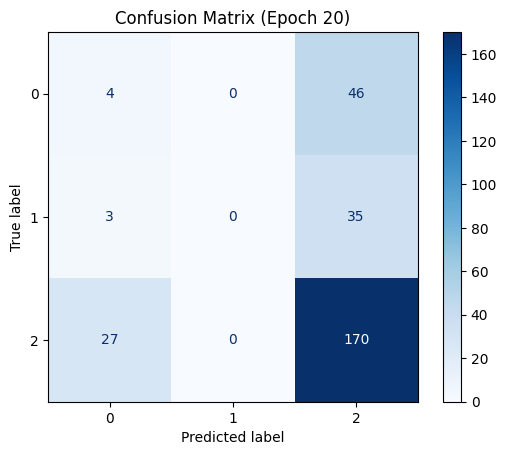

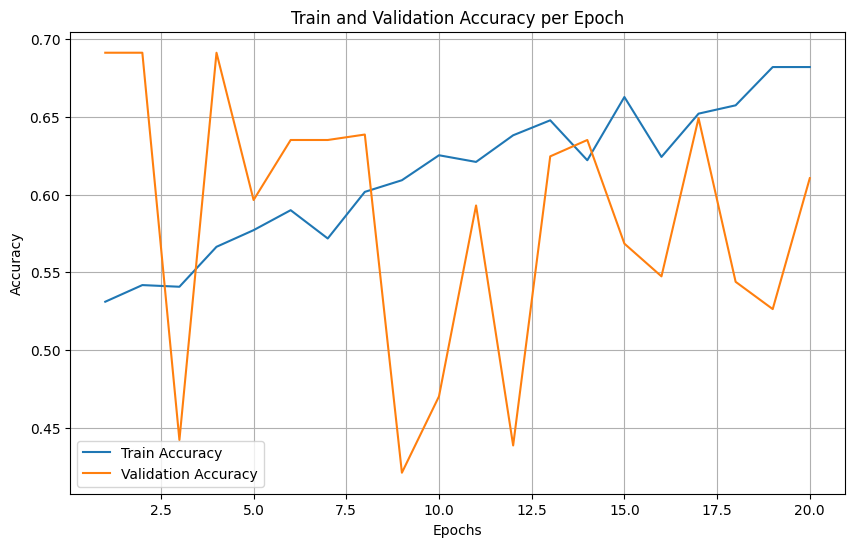

In [ ]:
# Configuration
BATCH_SIZE = 16
EPOCHS = 80
LEARNING_RATE = 0.0001 #the learning rate will be updated each 20 epochs by a factor of 0.1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # we ran this model using google colab A100 so we used Cuda
print(f"Using device: {DEVICE}")

# Dataset Class
class SpectrogramDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(labels_file)
        self.labels["label"] = self.labels["label"].astype(int)  # This is to ensure that labels are integers
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image not found: {img_name}")
        image = Image.open(img_name).convert("RGB")
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

train_image_dir = "/content/Unzipped/spectrograms_train/" #this path was meaningful when using colab, this is because on colab was easier to upload the collection of images as zipped folders
train_labels_file = "/content/Unzipped/spectrograms_train/spectrograms_train/labels.csv"
test_image_dir = "/content/Unzipped/spectrograms_test/"
test_labels_file = "/content/Unzipped/spectrograms_test/spectrograms_test/labels.csv"


# We define the transformer
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std) #we normalized the inputs to the model
])

train_dataset = SpectrogramDataset(image_dir=train_image_dir, labels_file=train_labels_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SpectrogramDataset(image_dir=test_image_dir, labels_file=test_labels_file, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# This is the setup of the model
num_classes = len(train_dataset.labels["label"].unique())
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', #this is a pretrained ViT provided by google
    num_labels=num_classes
)
model.to(DEVICE)

# Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1) # this has the job of updating the learning rate

# This function generates and plots a confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, epoch):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix (Epoch {epoch})")
    plt.show()

# Training Loop with Loss, Accuracy, and Validation Metrics
def train_model(threshold_loss=0.2): #optional threshold for stopping condition
    train_accuracies = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        # Initialize the training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Initialize validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        true_labels = []
        pred_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images).logits
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

                # alculate validation accuracies
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                # Collect labels
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(predicted.cpu().numpy())

        avg_val_loss = running_val_loss / len(test_loader)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # print the epoch's metrics
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.6f}, Accuracy: {train_accuracy * 100:.2f}%, "
              f"Val Loss: {avg_val_loss:.6f}, Val Accuracy: {val_accuracy * 100:.2f}%")

        # accuracy conditions for confusion matrix for printing confusion matrix
        if train_accuracy > 0.65 and val_accuracy > 0.55 and avg_loss < 0.82 : # this is a clear improvement over the simple random extraction of 33.3%
            print(f"Generating confusion matrix for Epoch {epoch + 1}...")
            plot_confusion_matrix(true_labels, pred_labels, epoch + 1)
            break

        # Update learning rate
        scheduler.step()
        print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.9f}")

        # Check for early stopping condition
        if avg_loss <= threshold_loss:
            print(f"Stopping early at epoch {epoch + 1} as loss reached {avg_loss:.4f}")
            break

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid()
    plt.show()

print("Starting Training...")
train_model()


New Test Set Accuracy: 40.70%


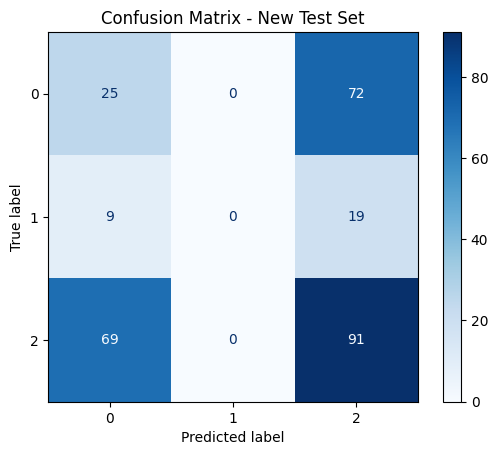

Predictions saved to new_test_predictions.csv


In [ ]:
# we then tried the same trained model on another test set taken from year 2015 to 2016

# New Test Set Directories
new_test_image_dir = "/content/Unzipped/spectrograms_test/"  # Replace with actual path
new_test_labels_file = "/content/Unzipped/spectrograms_test/spectrograms_test/labels.csv"  # Replace with actual path

# Create DataLoader for the New Test Set
new_test_dataset = SpectrogramDataset(image_dir=new_test_image_dir, labels_file=new_test_labels_file, transform=transform)
new_test_loader = DataLoader(new_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Function to Evaluate the Model on a New Test Set
def evaluate_new_test_set(loader, output_csv_path="new_test_predictions.csv"):
    model.eval()
    true_labels = []
    pred_labels = []
    image_names = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)

            # Store true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
            image_names.extend([new_test_dataset.labels.iloc[idx, 0] for idx in range(len(labels))])

    # Calculate the accuracy
    accuracy = np.sum(np.array(true_labels) == np.array(pred_labels)) / len(true_labels)
    print(f"New Test Set Accuracy: {accuracy * 100:.2f}%")

    # Generate and plot the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix - New Test Set")
    plt.show()

    # Save predictions to a CSV
    predictions_df = pd.DataFrame({"Image": image_names, "True Label": true_labels, "Predicted Label": pred_labels})
    predictions_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

# Evaluate the Model on the New Test Set
evaluate_new_test_set(new_test_loader)


### The model performed in a way that is not statistically significantly different than random guessing the labels and has an hard time generalizing well on unseen data.